# LaLiga DataFrame

In [1]:
import pandas as pd

# 데이터프레임으로 변환
laliga_train = pd.read_csv("../csv/LaLiga/train_La.csv")
print(laliga_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2908 entries, 0 to 2907
Data columns (total 48 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Rk       2908 non-null   int64  
 1   Player   2908 non-null   object 
 2   Nation   2908 non-null   object 
 3   Pos      2908 non-null   object 
 4   Squad    2908 non-null   object 
 5   Age      2908 non-null   int64  
 6   Born     2908 non-null   int64  
 7   90s      2908 non-null   float64
 8   Gls      2908 non-null   int64  
 9   Sh       2908 non-null   int64  
 10  SoT      2908 non-null   int64  
 11  SoT%     2404 non-null   float64
 12  Sh/90    2908 non-null   float64
 13  SoT/90   2908 non-null   float64
 14  G/Sh     2404 non-null   float64
 15  G/SoT    2018 non-null   float64
 16  Dist     2403 non-null   float64
 17  FK       2907 non-null   float64
 18  PK       2908 non-null   int64  
 19  PKatt    2908 non-null   int64  
 20  xG       2907 non-null   float64
 21  npxG     2907 

In [2]:
# Drop index column
laliga_train = laliga_train.drop(['Rk'], axis=1)
# print(laliga_train.info())

In [3]:
import numpy as np
# print(np.unique(laliga_train['Pos'].values))

replace_values = {
    'DF,FW': 'FW,DF',
    'DF,MF': 'MF,DF',
    'MF,FW': 'FW,MF'
}

laliga_train['Pos'] = laliga_train['Pos'].replace(replace_values)
# print(np.unique(laliga_train['Pos'].values))

# 결측치 채우기

In [4]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(missing_values=np.nan, strategy='mean')

numeric_laliga_train = laliga_train.select_dtypes(include=[np.number])
column_names = numeric_laliga_train.columns

imputer.fit(numeric_laliga_train)
numeric_laliga_train = imputer.transform(numeric_laliga_train)

numeric_laliga_train_df = pd.DataFrame(numeric_laliga_train, columns=column_names)

laliga_train[column_names] = numeric_laliga_train_df.round(2)

# 열 별로 NaN 값이 있는지 확인
column_nan = laliga_train.isna().any()
print(len(column_nan))
print(column_nan)

# laliga_train.info()

47
Player     False
Nation     False
Pos        False
Squad      False
Age        False
Born       False
90s        False
Gls        False
Sh         False
SoT        False
SoT%       False
Sh/90      False
SoT/90     False
G/Sh       False
G/SoT      False
Dist       False
FK         False
PK         False
PKatt      False
xG         False
npxG       False
npxG/Sh    False
G-xG       False
np:G-xG    False
Matches    False
Cmp        False
Att        False
Cmp%       False
TotDist    False
PrgDist    False
Ast        False
xAG        False
xA         False
A-xAG      False
KP         False
1/3        False
PPA        False
CrsPA      False
PrgP       False
Won        False
Lost       False
Won%       False
Tkl        False
TklW       False
Def 3rd    False
Mid 3rd    False
Att 3rd    False
dtype: bool


# Base Model for Best Scorer

### Real Top Scorer

In [ ]:
# Gls' 열에서 최대값을 찾습니다:
max_gls = laliga_train['Gls'].max()
print(max_gls)

players_with_max_gls = laliga_train[laliga_train['Gls'] == max_gls]['Player']
print(players_with_max_gls)

### Define object type Encoder

In [5]:
import category_encoders as ce

target_encoder = ce.TargetEncoder(cols=['Nation', 'Pos', 'Squad', 'Matches'])

### Encode

In [6]:
X = laliga_train.drop(columns=['Gls', 'Player'], axis=1)
y = laliga_train['Gls']

# 인코딩 수행
laliga_train_encoded = target_encoder.fit_transform(X, y)
# 데이터프레임 재구성
laliga_train_encoded['Gls'] = laliga_train['Gls']

X_encoded_train = laliga_train_encoded.drop(columns=['Gls'], axis=1)
y_encoded_train = laliga_train_encoded['Gls']

### Descriptive statistics

In [ ]:
y_encoded_train.describe()

### Divide the goal scoring into two categories

In [7]:
y_binned = pd.qcut(y_encoded_train, q=3, labels=False, duplicates='drop')
print(pd.Series(y_binned).value_counts())
# max(y_encoded_train.sort_values(ascending=True)[821:2908])

Gls
0    2088
1     820
Name: count, dtype: int64


### Train / Validate / Test Data Split

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_val_test, y_train, y_val_test = train_test_split(
    X_encoded_train, y_encoded_train,
    test_size=0.3,
    random_state=42,
    shuffle=True,
    stratify=y_binned # 비율을 유지하면서 데이터 분할
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val_test, y_val_test,
    test_size=0.5,
    random_state=42,
)

### RandomForest Regressor - Part 1

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.model_selection import KFold, GridSearchCV
# from sklearn.metrics import root_mean_squared_error
# from joblib import dump
# 
# kf = KFold(n_splits=5, shuffle=True, random_state=42)
# 
# random_forest = RandomForestRegressor(n_jobs=-1)
# 
# rf_params = {
#     'random_state': [42],
#     'n_estimators': [50, 100, 150, 200],
#     'max_depth': [3, 5, 7],
#     'max_features': ['sqrt', 'log2', 0.7, 0.9, None],
#     'min_samples_leaf': [3, 5, 7, 9, 11],
#     'ccp_alpha': [0.3, 0.5, 0.7, 0.9],
# }
# 
# gs = GridSearchCV(
#     estimator=random_forest,
#     param_grid=rf_params,
#     scoring='neg_root_mean_squared_error',
#     cv=kf
# )
# 
# gs.fit(X_train, y_train)
# 
# # 최적의 모델을 파일로 저장
# dump(gs.best_estimator_, 'top_scorer_model_ver1.joblib')

### Part 2

In [ ]:
# from joblib import load
# 
# # 나중에 모델을 불러올 때
# best_model_1st = load('top_scorer_model_ver1.joblib')
# 
# # 최적의 모델로 훈련 데이터를 사용해 최종 모델 훈련
# best_model_1st.fit(X_train, y_train)

### Performance Evaluation

In [ ]:
# # 훈련데이터 검증
# train_preds = best_model_1st.predict(X_train)
# train_rmse = root_mean_squared_error(y_train, train_preds)
# print(f'Train RMSE: {train_rmse:.2f}')
# train_score = best_model_1st.score(X_train, y_train)
# print(f'Best model Train R^2: {train_score:.2f}')
# 
# # 검증 데이터로 성능 평가
# val_preds = best_model_1st.predict(X_val)
# val_rmse = root_mean_squared_error(y_val, val_preds)
# print(f'Validation RMSE: {val_rmse:.2f}')
# val_score = best_model_1st.score(X_val, y_val)
# print(f'Best model Validation R^2: {val_score:.2f}')
# 
# # 테스트 데이터로 최종 성능 평가
# test_preds = best_model_1st.predict(X_test)
# test_rmse = root_mean_squared_error(y_test, test_preds)
# print(f'Test RMSE: {test_rmse:.2f}')
# test_score = best_model_1st.score(X_test, y_test)
# print(f'Best model Test R^2: {test_score:.2f}')                                 

In [ ]:
# # Predicted Validation DataFrame
# predicted_data = pd.DataFrame({
#     'Player': X_val.index.map(laliga_train['Player']),
#     'Predicted_Gls': val_preds
# })
# # 예측 득점왕
# predicted_top_scorer = predicted_data.loc[predicted_data['Predicted_Gls'].idxmax(), 'Player']
# 
# # Real Validation DataFrame
# real_validation_df = pd.DataFrame({
#     'Player': X_val.index.map(laliga_train['Player']),
#     'Gls': y_val
# })
# # Validation Data 내 실제 최다득점자
# actual_top_scorer = real_validation_df.loc[real_validation_df['Gls'].idxmax(), 'Player']
# 
# # 득점왕 비교
# if actual_top_scorer == predicted_top_scorer:
#     print(f"모델이 정확하게 최다득점자를 예측했습니다: {actual_top_scorer}")
# else:
#     print(f"모델의 예측 최다득점자: {predicted_top_scorer}, 실제 최다득점자: {actual_top_scorer}")

### 2nd RandomForest
    - Discard 'max_feature' & 'ccp_alpha'

In [9]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from joblib import dump

kf = KFold(n_splits=5, shuffle=True, random_state=42)

random_forest = RandomForestRegressor(n_jobs=-1)

rf_params = {
    'random_state': [42],
    'n_estimators': [50, 100, 150, 200],
    'max_depth': [3, 5, 7],
    'min_samples_leaf': [3, 5, 7, 9, 11],
}

gs = GridSearchCV(
    estimator=random_forest,
    param_grid=rf_params,
    scoring='neg_root_mean_squared_error',
    cv=kf
)

gs.fit(X_train, y_train)

# 최적의 모델을 파일로 저장
dump(gs.best_estimator_, 'top_scorer_model_ver2.joblib')

['top_scorer_model_ver2.joblib']

In [10]:
from joblib import load

# 나중에 모델을 불러올 때
best_model_2nd = load('top_scorer_model_ver2.joblib')

# 최적의 모델로 훈련 데이터를 사용해 최종 모델 훈련
best_model_2nd.fit(X_train, y_train)

RandomForestRegressor(max_depth=7, min_samples_leaf=3, n_estimators=200,
                      n_jobs=-1, random_state=42)

### Performance Evaluation

In [11]:
# 훈련데이터 검증
train_preds = best_model_2nd.predict(X_train)
train_rmse = root_mean_squared_error(y_train, train_preds)
print(f'Train RMSE: {train_rmse:.2f}')
train_score = best_model_2nd.score(X_train, y_train)
print(f'Best model Train R^2: {train_score:.2f}')

# 검증 데이터로 성능 평가
val_preds = best_model_2nd.predict(X_val)
val_rmse = root_mean_squared_error(y_val, val_preds)
print(f'Validation RMSE: {val_rmse:.2f}')
val_score = best_model_2nd.score(X_val, y_val)
print(f'Best model Validation R^2: {val_score:.2f}')

# 테스트 데이터로 최종 성능 평가
test_preds = best_model_2nd.predict(X_test)
test_rmse = root_mean_squared_error(y_test, test_preds)
print(f'Test RMSE: {test_rmse:.2f}')
test_score = best_model_2nd.score(X_test, y_test)
print(f'Best model Test R^2: {test_score:.2f}')

Train RMSE: 0.26
Best model Train R^2: 0.99
Validation RMSE: 0.37
Best model Validation R^2: 0.98
Test RMSE: 0.43
Best model Test R^2: 0.98


In [12]:
# Predicted Validation DataFrame
predicted_data = pd.DataFrame({
    'Player': X_val.index.map(laliga_train['Player']),
    'Predicted_Gls': val_preds
})
# 예측 득점왕
predicted_top_scorer = predicted_data.loc[predicted_data['Predicted_Gls'].idxmax(), 'Player']

# Real Validation DataFrame
real_validation_df = pd.DataFrame({
    'Player': X_val.index.map(laliga_train['Player']),
    'Gls': y_val
})
# Validation Data 내 실제 최다득점자
actual_top_scorer = real_validation_df.loc[real_validation_df['Gls'].idxmax(), 'Player']

# 득점왕 비교
if actual_top_scorer == predicted_top_scorer:
    print(f"모델이 정확하게 최다득점자를 예측했습니다: {actual_top_scorer}")
else:
    print(f"모델의 예측 최다득점자: {predicted_top_scorer}, 실제 최다득점자: {actual_top_scorer}")

모델이 정확하게 최다득점자를 예측했습니다: Borja Iglesias


# Apply Model to Test Data

## Load Test data

In [13]:
laliga_test = pd.read_csv('../csv/LaLiga/2023-2024_La.csv', encoding='cp949')

laliga_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 609 entries, 0 to 608
Data columns (total 48 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Rk       609 non-null    int64  
 1   Player   609 non-null    object 
 2   Nation   609 non-null    object 
 3   Pos      609 non-null    object 
 4   Squad    609 non-null    object 
 5   Age      607 non-null    object 
 6   Born     607 non-null    float64
 7   90s      609 non-null    float64
 8   Gls      609 non-null    int64  
 9   Sh       609 non-null    int64  
 10  SoT      609 non-null    int64  
 11  SoT%     493 non-null    float64
 12  Sh/90    609 non-null    float64
 13  SoT/90   609 non-null    float64
 14  G/Sh     493 non-null    float64
 15  G/SoT    413 non-null    float64
 16  Dist     493 non-null    float64
 17  FK       606 non-null    float64
 18  PK       609 non-null    int64  
 19  PKatt    609 non-null    int64  
 20  xG       606 non-null    float64
 21  npxG     606 non

In [14]:
laliga_test = laliga_test.drop(['Rk'], axis=1)

replace_values = {
    'DF,FW': 'FW,DF',
    'DF,MF': 'MF,DF',
    'MF,FW': 'FW,MF'
}

laliga_test['Pos'] = laliga_test['Pos'].replace(replace_values)

In [15]:
# 'Age' 열에서 '-' 앞의 정보만 추출하여 새로운 열로 저장
laliga_test['Age'] = laliga_test['Age'].str.split('-').str[0]

# 숫자로 변환할 수 없는 값이 있는 경우 NaN으로 변경(object -> NaN)
laliga_test['Age'] = pd.to_numeric(laliga_test['Age'], errors='coerce')

## 결측치 채우기

In [16]:
numeric_laliga_test = laliga_test.select_dtypes(include=[np.number])
column_names = numeric_laliga_test.columns

imputer.fit(numeric_laliga_test)
numeric_laliga_test = imputer.transform(numeric_laliga_test)

numeric_laliga_test_df = pd.DataFrame(numeric_laliga_test, columns=column_names)

laliga_test[column_names] = numeric_laliga_test_df.round(2)

# 열 별로 NaN 값이 있는지 확인
column_nan = laliga_test.isna().any()
print(column_nan)

Player     False
Nation     False
Pos        False
Squad      False
Age        False
Born       False
90s        False
Gls        False
Sh         False
SoT        False
SoT%       False
Sh/90      False
SoT/90     False
G/Sh       False
G/SoT      False
Dist       False
FK         False
PK         False
PKatt      False
xG         False
npxG       False
npxG/Sh    False
G-xG       False
np:G-xG    False
Matches    False
Cmp        False
Att        False
Cmp%       False
TotDist    False
PrgDist    False
Ast        False
xAG        False
xA         False
A-xAG      False
KP         False
1/3        False
PPA        False
CrsPA      False
PrgP       False
Won        False
Lost       False
Won%       False
Tkl        False
TklW       False
Def 3rd    False
Mid 3rd    False
Att 3rd    False
dtype: bool


## Independent Variable, Dependent Variable

In [17]:
X_test = laliga_test.drop(columns=['Gls', 'Player'], axis=1)
y_test = laliga_test['Gls']

laliga_test_encoded = target_encoder.fit_transform(X_test, y_test)

laliga_test_encoded['Gls'] = laliga_test['Gls']

X_encoded_test = laliga_test_encoded.drop(columns=['Gls'], axis=1)
y_encoded_test = laliga_test_encoded['Gls']

## 1st Model Test

In [ ]:
# test_preds = best_model_1st.predict(X_encoded_test)
# rmse = root_mean_squared_error(y_encoded_test, test_preds)
# print(f'1st Random Forest evaluation by RMSE: {rmse:.2f}')
# test_coef = best_model_1st.score(X_encoded_test, y_encoded_test)
# print(f'1st Random Forest evaluation by coefficient: {test_coef:.2f}')
# 
# copied_X_test = X_encoded_test.copy()
# 
# copied_X_test['Predicted_Gls'] = test_preds
# max_predicted_index = copied_X_test['Predicted_Gls'].idxmax()
# predicted_top_scorer = laliga_test.loc[max_predicted_index, 'Player']
# 
# print(f'Top Scorer in the 23-24 season predicted by the model: {predicted_top_scorer}')

## 2nd Model Test

In [18]:
test_preds = best_model_2nd.predict(X_encoded_test)
rmse = root_mean_squared_error(y_encoded_test, test_preds)
print(f'2nd Random Forest evaluation by RMSE: {rmse:.2f}')
test_coef = best_model_2nd.score(X_encoded_test, y_encoded_test)
print(f'2nd Random Forest evaluation by coefficient: {test_coef:.2f}')

copied_X_test = X_encoded_test.copy()

copied_X_test['Predicted_Gls'] = test_preds
max_predicted_index = copied_X_test['Predicted_Gls'].idxmax()
predicted_top_scorer = laliga_test.loc[max_predicted_index, 'Player']

print(f'Top Scorer in the 23-24 season predicted by the model: {predicted_top_scorer}')

2nd Random Forest evaluation by RMSE: 0.47
2nd Random Forest evaluation by coefficient: 0.98
Top Scorer in the 23-24 season predicted by the model: Artem Dovbyk


## 2차 모델의 피처 중요도

In [19]:
feature_importances = best_model_2nd.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)

    Feature  Importance
17       xG    0.866147
20     G-xG    0.060723
21  np:G-xG    0.024859
18     npxG    0.016596
11     G/Sh    0.010530
7       SoT    0.004812
6        Sh    0.004253
12    G/SoT    0.002169
10   SoT/90    0.000963
29      xAG    0.000788
13     Dist    0.000681
30       xA    0.000507
34      PPA    0.000454
19  npxG/Sh    0.000453
36     PrgP    0.000447
15       PK    0.000440
25     Cmp%    0.000389
32       KP    0.000349
39     Won%    0.000329
2     Squad    0.000319
23      Cmp    0.000312
9     Sh/90    0.000305
16    PKatt    0.000289
33      1/3    0.000281
42  Def 3rd    0.000277
26  TotDist    0.000204
38     Lost    0.000203
28      Ast    0.000168
37      Won    0.000167
31    A-xAG    0.000163
41     TklW    0.000163
27  PrgDist    0.000163
8      SoT%    0.000152
5       90s    0.000152
24      Att    0.000145
3       Age    0.000134
43  Mid 3rd    0.000100
4      Born    0.000096
44  Att 3rd    0.000080
35    CrsPA    0.000080
14       FK    0

## Partial Dependence Plot

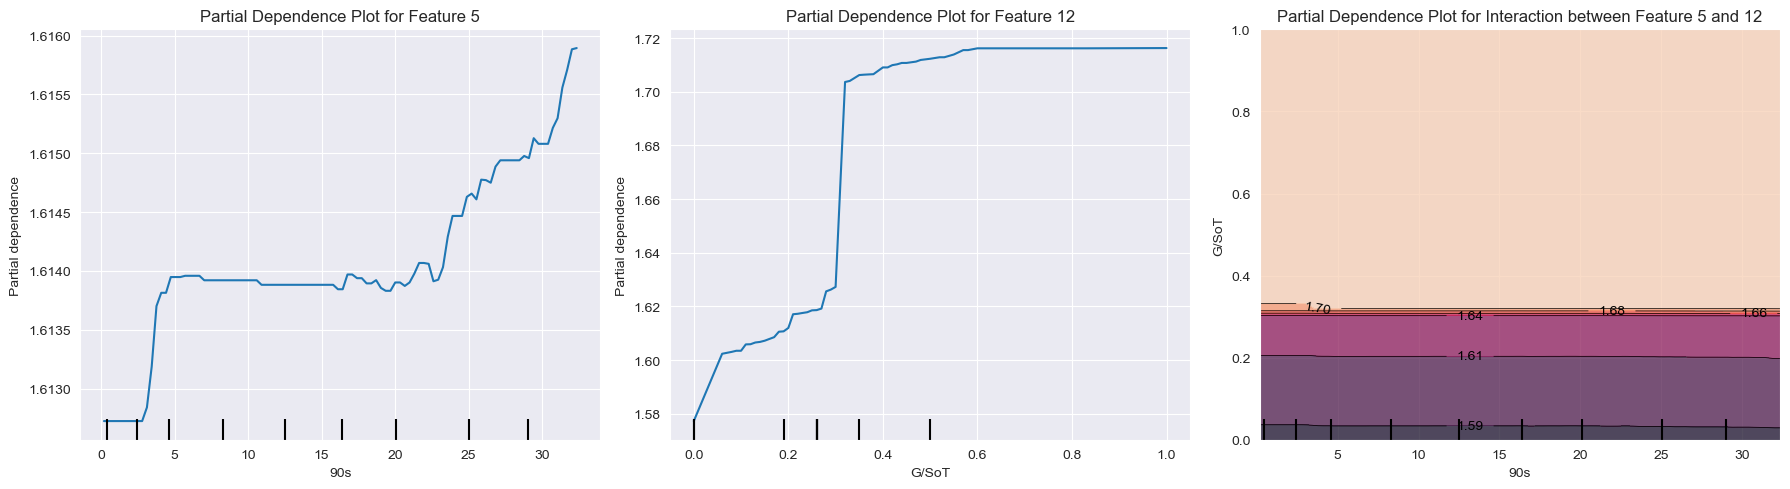

In [20]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

_, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 5))

# Plot partial dependence for feature 5
PartialDependenceDisplay.from_estimator(best_model_2nd, X_encoded_test, features=[5], ax=ax[0])
ax[0].set_title('Partial Dependence Plot for Feature 5')

# Plot partial dependence for feature 12
PartialDependenceDisplay.from_estimator(best_model_2nd, X_encoded_test, features=[12], ax=ax[1])
ax[1].set_title('Partial Dependence Plot for Feature 12')

# Plot partial dependence for interaction between features 5 and 12
PartialDependenceDisplay.from_estimator(best_model_2nd, X_encoded_test, features=[(5, 12)], ax=ax[2])
ax[2].set_title('Partial Dependence Plot for Interaction between Feature 5 and 12')

plt.tight_layout()
plt.show()

## Premier League Test

In [ ]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import category_encoders as ce
from sklearn.metrics import mean_squared_error

class PremierLeagueDataProcessor:
    def __init__(self, file_path, encoding='cp949'):
        self.file_path = file_path
        self.encoding = encoding
        self.imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
        self.target_encoder = ce.TargetEncoder(cols=['Nation', 'Pos', 'Squad', 'Matches'])
        self.df = None
        self.processed_data = None

    def load_data(self):
        self.df = pd.read_csv(self.file_path, encoding=self.encoding)
        self.df.info()
        self.df = self.df.drop(['Rk'], axis=1)
        
        replace_values = {
            'DF,FW': 'FW,DF',
            'DF,MF': 'MF,DF',
            'MF,FW': 'FW,MF'
        }
        
        self.df['Pos'] = self.df['Pos'].replace(replace_values)

        return self.df

    def impute_values(self):
        numeric_data = self.df.select_dtypes(include=[np.number])
        col_names = numeric_data.columns
        self.imputer.fit(numeric_data)
        imputed_data = self.imputer.transform(numeric_data)
        self.df[col_names] = pd.DataFrame(imputed_data, columns=col_names).round(2)
        return self.df

    def preprocess_data(self):
        X = self.df.drop(columns=['Player', 'Gls'], axis=1)
        y = self.df['Gls']

        self.processed_data = self.target_encoder.fit_transform(X, y)
        self.processed_data = pd.DataFrame(self.processed_data, columns=X.columns)
        self.processed_data['Gls'] = y.values

        X_test = self.processed_data.drop(columns=['Gls'], axis=1)
        y_test = self.processed_data['Gls']
        return X_test, y_test

    def evaluate_model(self, model, X_test, y_test):
        preds = model.predict(X_test)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        score = model.score(X_test, y_test)
        return rmse, score

# Usage example
file_path = "../csv/2023-2024_Pre.csv"
processor = PremierLeagueDataProcessor(file_path)

processor.load_data()
processor.impute_values()
print(">>> Preprocessing data...")
processor.df.info()

# 열 별로 NaN 값이 있는지 확인
column_nan = processor.df.isna().any()
print(column_nan)

X_encoded_test, y_encoded_test = processor.preprocess_data()

## 1st Model Test

In [ ]:
# test_preds = best_model_1st.predict(X_encoded_test)
# rmse, test_coef = processor.evaluate_model(best_model_1st, X_encoded_test, y_encoded_test)
# 
# print(f'1st Random Forest evaluation by RMSE: {rmse:.2f}')
# print(f'1st Random Forest evaluation by coefficient: {test_coef:.2f}')
# 
# copied_X_test = X_encoded_test.copy()
# 
# copied_X_test['Predicted_Gls'] = test_preds
# max_predicted_index = copied_X_test['Predicted_Gls'].idxmax()
# predicted_top_scorer = processor.df.loc[max_predicted_index, 'Player']
# 
# print(f'Top Scorer in the 23-24 season predicted by the model: {predicted_top_scorer}')

## 2nd Model Test

In [ ]:
test_preds = best_model_2nd.predict(X_encoded_test)
rmse, test_coef = processor.evaluate_model(best_model_2nd, X_encoded_test, y_encoded_test)

print(f'2nd Random Forest evaluation by RMSE: {rmse:.2f}')
print(f'2nd Random Forest evaluation by coefficient: {test_coef:.2f}')

copied_X_test = X_encoded_test.copy()

copied_X_test['Predicted_Gls'] = test_preds
max_predicted_index = copied_X_test['Predicted_Gls'].idxmax()
predicted_top_scorer = processor.df.loc[max_predicted_index, 'Player']

print(f'Top Scorer in the 23-24 season predicted by the model: {predicted_top_scorer}')

## 2차모델의 피처 중요도

In [ ]:
feature_importances = best_model_2nd.feature_importances_
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df)